In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine

%matplotlib inline

plt.rcParams['figure.figsize'] = (12,9)

In [4]:
wine_data = load_wine()

wine_df = pd.DataFrame(data=wine_data.data, columns=wine_data.feature_names)

wine_df['target'] = wine_data.target

c:\Users\05442188689\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\05442188689\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='features', ylabel='value'>

c:\Users\05442188689\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


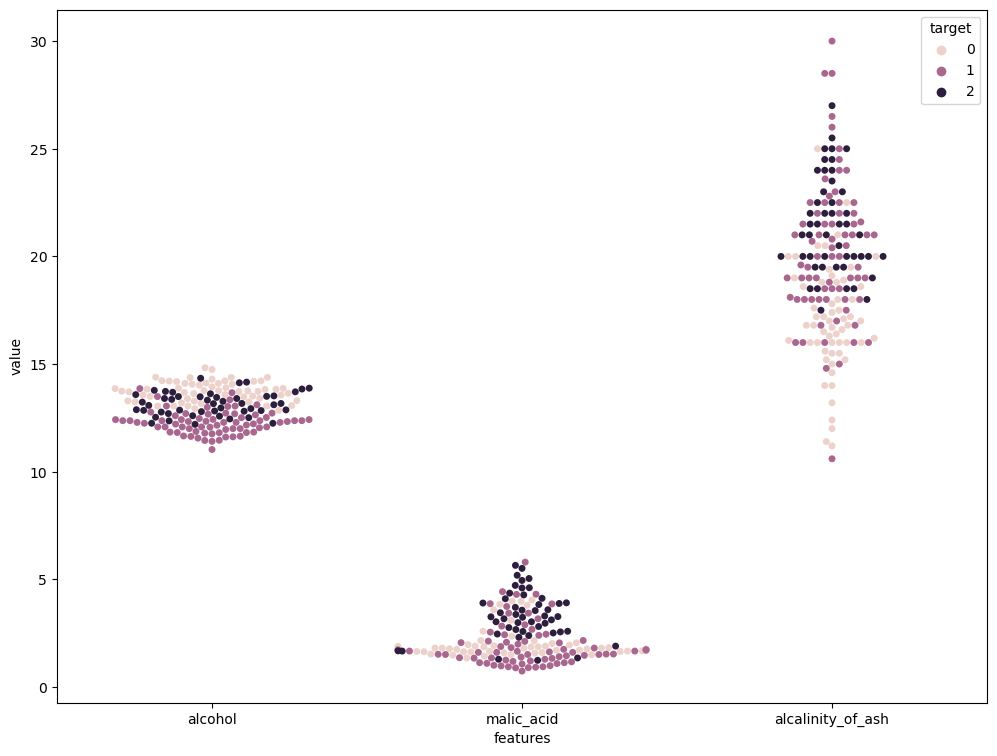

In [6]:
data_to_plot = pd.melt(wine_df[['alcohol', 'malic_acid', 'alcalinity_of_ash', 'target']], id_vars='target', var_name='features', value_name='value')

sns.swarmplot(data=data_to_plot, x='features', y='value', hue='target')

In [7]:
from sklearn.model_selection import train_test_split

X = wine_df.drop(['target'], axis=1)
y = wine_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,shuffle=True, stratify=y, random_state=42)

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

gbc = GradientBoostingClassifier(max_depth=5, random_state=42)

gbc.fit(X=X_train, y=y_train)

preds = gbc.predict(X=X_test)

f1_score_all = f1_score(y_test, preds, average='weighted')

print(f1_score_all)

0.9077681577681577


## Feature selection techniques

In [12]:
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [13]:
X_train_v1.var(axis=0)

alcohol                             0.658341
malic_acid                          1.123507
ash                                 0.072433
alcalinity_of_ash                  11.471279
magnesium                         232.071532
total_phenols                       0.393226
flavanoids                          0.912299
nonflavanoid_phenols                0.013873
proanthocyanins                     0.335108
color_intensity                     5.669722
hue                                 0.052891
od280/od315_of_diluted_wines        0.470021
proline                         94906.710923
dtype: float64

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_X_train_v1 = scaler.fit_transform(X_train_v1)

In [17]:
scaled_X_train_v1.var(axis=0)

array([0.04522384, 0.04352695, 0.02076785, 0.03023374, 0.02719754,
       0.04637992, 0.07828214, 0.05504516, 0.03328847, 0.04094397,
       0.03467828, 0.06639094, 0.06152349])

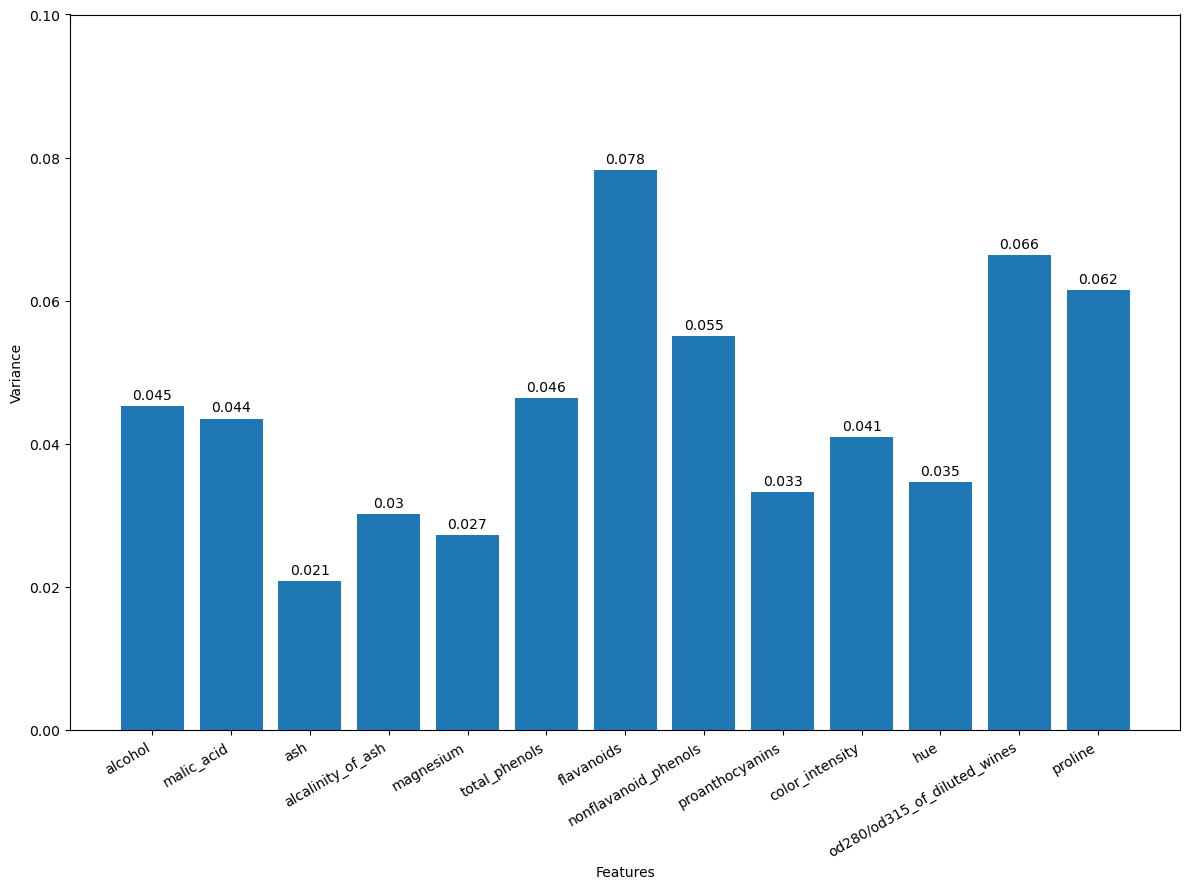

In [18]:
fig, ax = plt.subplots()

x = X.columns
y = scaled_X_train_v1.var(axis=0)

ax.bar(x,y)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.set_ylim(0,0.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.001, s=str(round(value,3)), ha='center')

fig.autofmt_xdate()
plt.tight_layout()

In [19]:
sel_X_train_v1 = X_train_v1.drop(['ash', 'magnesium'], axis=1 )
sel_X_test_v1 = X_test_v1.drop(['ash', 'magnesium'], axis=1 )

gbc.fit(sel_X_train_v1, y_train_v1)

var_preds = gbc.predict(sel_X_test_v1)

f1_score_var = f1_score(y_test_v1, var_preds, average='weighted')

print(f1_score_var)

0.9632208787381201


## K-best features

In [20]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

f1_score_list = []

for k in range(1,14):
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_train_v2, y_train_v2)

    sel_X_train_v2 = selector.transform(X_train_v2)
    sel_X_test_v2 = selector.transform(X_test_v2)

    gbc.fit(sel_X_train_v2, y_train_v2)
    kbest_preds = gbc.predict(sel_X_test_v2)

    f1_score_kbest = round(f1_score(y_test_v2, kbest_preds, average='weighted'), 3)

    f1_score_list.append(f1_score_kbest)

In [25]:
f1_score_list

[0.759,
 0.926,
 0.981,
 0.981,
 0.981,
 0.981,
 0.981,
 0.963,
 0.963,
 0.963,
 0.945,
 0.908,
 0.908]

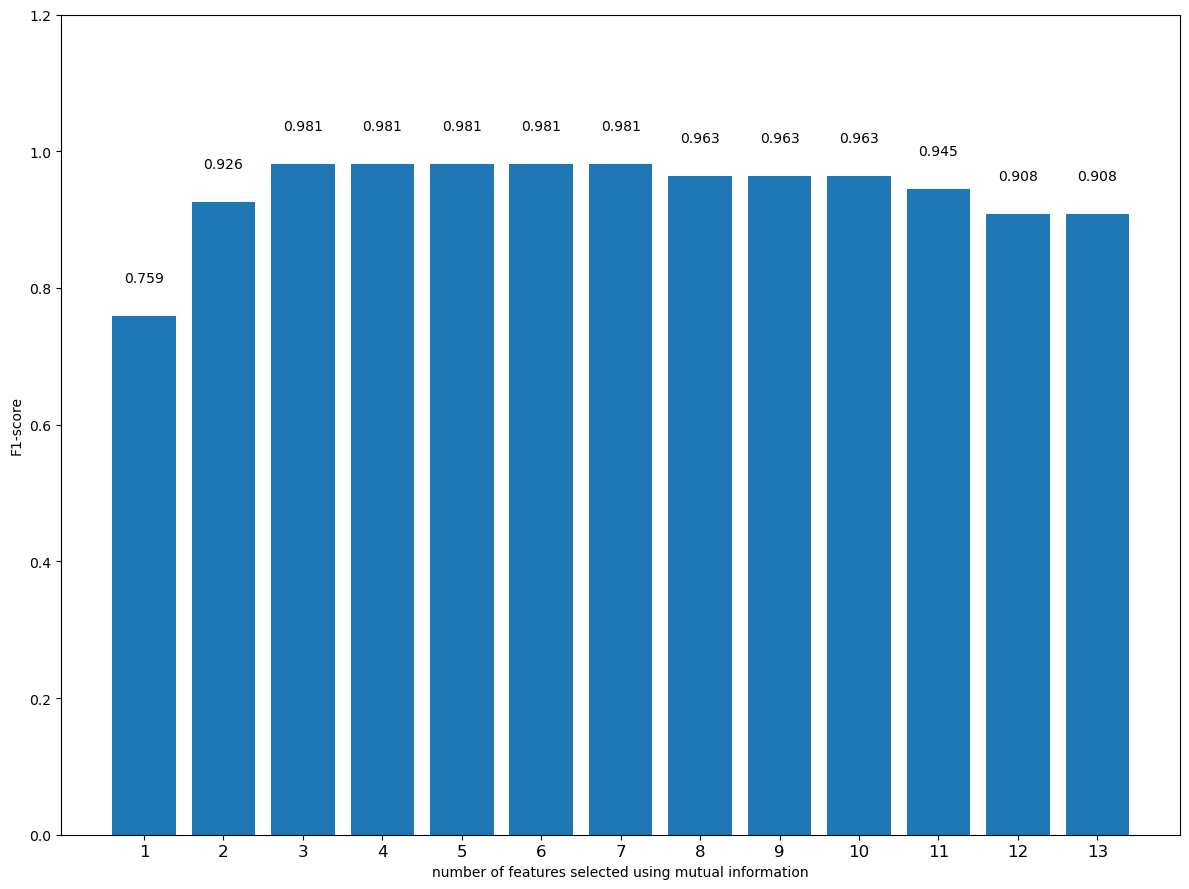

In [30]:
fig, ax = plt.subplots()

x = np.arange(1,14)
y = f1_score_list

ax.bar(x,y)
ax.set_xlabel('number of features selected using mutual information')
ax.set_ylabel('F1-score')
ax.set_ylim(0,1.2)
ax.set_xticks(np.arange(1,14))
ax.set_xticklabels(np.arange(1,14),fontsize=12)

for index, value in enumerate(y):
    plt.text(x=index+1, y=value+0.05, s=str(value), ha='center')

# fig.autofmt_xdate()
plt.tight_layout()

In [31]:
selector = SelectKBest(mutual_info_classif, k=3)
selector.fit(X_train_v2, y_train_v2)

selected_feature_mask = selector.get_support()

selected_features = X_train_v2.columns[selected_feature_mask]

selected_features

Index(['flavanoids', 'color_intensity', 'proline'], dtype='object')